In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements

## Utilities

In [13]:
def create_site_get_label(L, p):
    '''
    creating a site percolation and then do coloring 
    and retruning some statistics.
    '''
    # create the site percolation
    site = np.random.rand(L,L) < p
    # the label of each site after clustering
    label, n_clusters = measurements.label(site)
    # the area of each cluster
    area = measurements.sum(site, label, index=np.arange(label.max() + 1))
    area = area.astype(int)
    
    return site, label, n_clusters, area

In [14]:
def plot_sites(site_list, label_list=None, show_axes=True):

    if label_list is None:
        label_list = [None for i in range(len(site_list))] 
        
    nrow, ncol = 1, len(site_list)
    plt.figure(figsize=(6, 4))

    i = 0
    for site, label in zip(site_list, label_list):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(site)
        if not show_axes:
            plt.axis('off')
        if label is not None:
            plt.title(label)
        i += 1
    # end for i

## Init Data

In [15]:
pc = 0.5928   # the critical thershold

# Just for testing

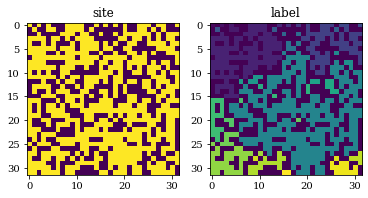

In [16]:
site, label, n_clusters, area = create_site_get_label(32, pc)
plot_sites([site, label], ['site', 'label'])

# Cluster Number Density

The cluster number density $n(s,p)$ is the probability for a site to be a particular site in a cluster of size $s$.

We can calculate using below definitions: \
$p$: the percolation control parameter \
$s$: the cluster size \
$M$: the number of realiztions \
$N_s(M)$: the number of clusters of size s measured in $M$ realizations of the percolation system \
estimation of cluster number density $n(s, p) \approx \frac{ N_s(M)}{L^2  M}$


In [ ]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import trange

def cluster_number_density(L, p, M, show_progress=True): 
    
    all_area = np.array([], dtype=int)  
    
    if show_progress:
        myrange = trange(M)
    else:
        myrange = range(M)
    
    for i in myrange:
        site, label, n_clusters, area = create_site_get_label(L, p)
        all_area = np.append(all_area, area)
    # end for i
    
    NsM = np.bincount(all_area)
    nsp = NsM.astype(float) / (L**2 * M)
    
    return nsp, len(all_area)
    

## Statistics

In [ ]:
L = 1024
n_realizations = 5000
p_list = [pc, 0.59, 0.6, 0.58, 0.61, 0.5, 0.7] 
p_list.sort()

In [ ]:
nsp_list, ndata_list = [], []

for p in p_list:
    print ('# L={}, p={}'.format(L, p), flush=True)
    nsp, ndata = cluster_number_density(L, p, n_realizations, show_progress=True)
    nsp_list.append(nsp)
    ndata_list.append(ndata)
    

## Plot

In [ ]:
import histogram

i = 0
plt.figure(figsize=(9,6))
for p in p_list:
    nsp, ndata = nsp_list[i], ndata_list[i]
    
    s = np.arange(len(nsp))
    x, y, dx = histogram.hist(s[1:], nsp[1:], 
                              nbins=75, density=False, log_bin=True)
    
    x, y = x[10:], y[10:]
    
    print('p={}, ndata={}'.format(p, ndata))
     

    plt.loglog(x, y, 
               label='$p={}$'.format(p),
               marker='o', 
               ls='',
               markersize=5, )
    i += 1

# end for

plt.title('$L={}, p_c={}$'.format(L, pc))
plt.xlabel('$s$')
plt.ylabel('$n(s,p)$')
plt.legend(loc='best', frameon=False, bbox_to_anchor=(1.01, 1))
plt.savefig('n(s,p)--L_{}_M_{}.pdf'.format(L, n_realizations), 
            pad_inches=0.05, bbox_inches='tight')

## Average (mean) cluster size

The average cluster size S is defined as follows: We point to a random point in the percolation system. What is the average size of the cluster connected to that point?

$S(p) = \langle s \rangle = \sum_s s \left ( \frac{s n(s,p)}{\sum_s s n(s,p)} \right ) $ 

But in simulation, we just can estimate the value of $S(p)$ which is $\approx \sum_s s^2 N_s / L^2 = \sum_i s_i^2 / L^2$, \
where $N_s$ is the number of clusters of size s measured in current realization. It is worth noting that we should ignore the infinite cluster from above relation. 

In [ ]:
def average_cluser_size(L, p, M, show_progress=True): 
    
    if show_progress:
        myrange = trange(M)
    else:
        myrange = range(M)
    
    S = 0
    for i in myrange:
        site, label, n_clusters, area = create_site_get_label(L, p)
        
        # Remove spanning cluster by setting its area to zero
        perc_x = np.intersect1d(label[0,:], label[-1,:]) # spanning along x axis
        perc = perc_x[np.where(perc_x > 0)] 
        if len(perc) > 0: 
            area[perc[0]] = 0
        S += np.sum(area * area)  
        
    # end for i
    
    return S / (M * L**2)
    

In [ ]:
L = 128
n_realizations = 1000

p_list = [] \
+ [round(0.6 - i*0.01, 4) for i in range(0, 25)] \
+ [round(0.6 + i*0.01, 4) for i in range(0, 25)]

p_list.sort()

In [ ]:
Sp_list = []

for p in p_list:
    print ('# p={}'.format(p), flush=True)
    Sp = average_cluser_size(L, p, n_realizations, show_progress=False)
    Sp_list.append(Sp)


# Plot

In [ ]:
plt.plot(p_list, Sp_list, '.--', lw=0.2)
plt.title('$L={}, pc={}$'.format(L, pc))
plt.grid()
plt.axvline(x=pc, color='k', lw=1, ls='--')
plt.xlabel('$p$')
plt.ylabel('$S(p)$')
plt.savefig('S(p)--L_{}_M_{}.pdf'.format(L, n_realizations), 
            pad_inches=0.05, bbox_inches='tight')